Example showing how to compute different reaction times in the system monitoring task.

In [1]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matbii.extras.analysis import (
    EventLogParser,
    get_system_monitoring_task_events,
    get_acceptable_intervals,
    get_unacceptable_intervals,
    get_guidance_intervals,
    get_mouse_motion_events,
    get_start_and_end_time,
    get_attention_intervals,
)
from icua.extras.analysis.plot import plot_timestamps, plot_intervals

TRACKING_COLOR = "#4363d8"
RESOURCE_MANAGEMENT_COLOR = "#3cb44b"
SYSTEM_MONITORING_COLOR = "#e6194B"

# choose your own event log file
PATH = "example_logs/example-system-monitoring-only/" 

parser = EventLogParser()
parser.discover_event_classes("matbii")
# this may not work if other log files are present in the directory
path = parser.get_event_log_file(PATH)
events = list(parser.parse(path, relative_start=True))

# 1.1 Get when the task was in an acceptable state
# `acceptable_intervals` contains N pairs (t1, t2) which are event timestamps recording when the guidance agent judged the task to be acceptable.
acceptable_intervals = dict(get_acceptable_intervals(events))["system_monitoring"]

# 1.2 Get when the task was in an unacceptable state
# `unacceptable_intervals` contains N pairs (t1, t2) which are event timestamps recording when the guidance agent judged the task to be unacceptable. 
# Using this function will avoid some issues that you woould encounter just by "inverting" `acceptable_intervals` - it handles the initial period before tasks are active and properly handles start/end times.
unacceptable_intervals = dict(get_unacceptable_intervals(events))["system_monitoring"]

# 1.3 Get guidance intervals
guidance_intervals = dict(get_guidance_intervals(events))["system_monitoring"]

# 1.4 Get attention intervals, you can use gaze, fixations, mouse motion, or other user input (clicks/keyboard) 
# We will use mouse motion as a proxy for attention.
mouse_motion_df = get_mouse_motion_events(parser, events)
attention_intervals = dict(get_attention_intervals(mouse_motion_df))["system_monitoring"]

# 2. Get the relevant task data
df = get_system_monitoring_task_events(parser, events)
# `df` is a pandas DataFrame that contains a running update of the state of the task (one entry each time the task state was changed).

# 3. Get the start and end time of the experiment
# these will be in relative time (seconds) if `relative_start` was set to True (above).
start_time, end_time = get_start_and_end_time(events)


c:\Users\brjw\anaconda3\envs\star-ray\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-12 12:04:02,149	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
DEBUG: Checking libcairo installation...


DEBUG | C:\Users\brjw\Documents\repos\dicelab\matbii\matbii\utils\_const.py:11 | `matbii` package path: C:/Users/brjw/Documents/repos/dicelab/matbii/matbii
DEBUG | C:\Users\brjw\Documents\repos\dicelab\matbii\matbii\utils\_const.py:19 | Checking tracking path: C:/Users/brjw/Documents/repos/dicelab/matbii/matbii/tasks/tracking
DEBUG | C:\Users\brjw\Documents\repos\dicelab\matbii\matbii\utils\_const.py:19 | Checking system_monitoring path: C:/Users/brjw/Documents/repos/dicelab/matbii/matbii/tasks/system_monitoring
DEBUG | C:\Users\brjw\Documents\repos\dicelab\matbii\matbii\utils\_const.py:19 | Checking resource_management path: C:/Users/brjw/Documents/repos/dicelab/matbii/matbii/tasks/resource_management


DEBUG: user input types: (<class 'star_ray_pygame.event.MouseButtonEvent'>, <class 'star_ray_pygame.event.MouseMotionEvent'>, <class 'star_ray.event.user_event.keyevent.KeyEvent'>, <class 'star_ray.event.user_event.windowevent.WindowCloseEvent'>, <class 'star_ray.event.user_event.windowevent.WindowOpenEvent'>, <class 'star_ray.event.user_event.windowevent.WindowFocusEvent'>, <class 'star_ray.event.user_event.windowevent.WindowMoveEvent'>, <class 'star_ray.event.user_event.windowevent.WindowResizeEvent'>)
C:\Users\brjw\Documents\repos\dicelab\matbii\matbii\extras\analysis\get_task.py:175: UserWarning: Error sensing data for event 0 of type <class 'star_ray_xml.query.Update'>.
  warnings.warn(


NOTE: There may be small discrepencies in whether the state was _actually_ acceptable (according to its state). This is because the guidance agent is working from observations, which may be outdated from the users perspective if an update happens after it has made the observation but BEFORE the avatar renders (advancing to the next frame).

-------------------------------------

First, lets plot the timestamps as a sanity check.

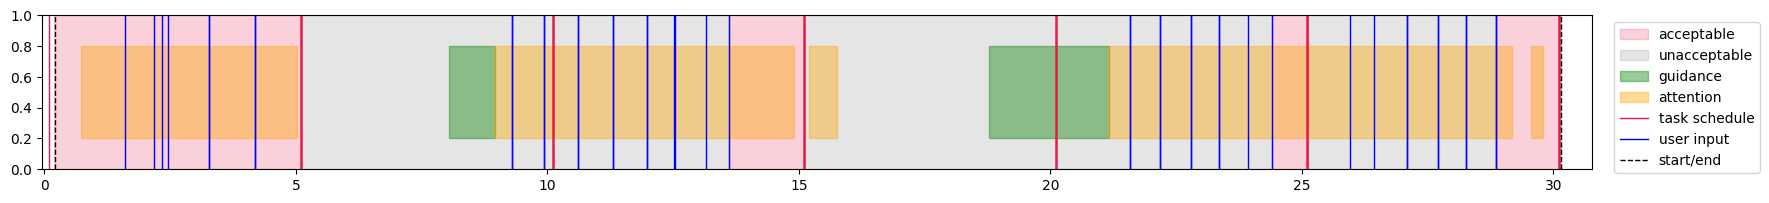

In [16]:

fig, ax = plt.subplots(figsize=(20, 2))
# plot the acceptable intervals
fig = plot_intervals(acceptable_intervals, color=SYSTEM_MONITORING_COLOR, alpha=0.2, label="acceptable", ax=ax)
# plot the unacceptable intervals
fig = plot_intervals(unacceptable_intervals, color="black", alpha=0.1, label="unacceptable", ax=ax)
# plot the guidance intervals
fig = plot_intervals(guidance_intervals, color="green", alpha=0.4, ax=ax,label="guidance", ymin=0.2, ymax=0.8)
# plot attending on task (based on mouse motion)
fig = plot_intervals(attention_intervals, color="orange", alpha=0.4, ax=ax, label="attention", ymin=0.2, ymax=0.8)



# plot the timestamps for the task changed its state due to the task specific agent.
fig = plot_timestamps(df["timestamp"][~df["user"]], color=SYSTEM_MONITORING_COLOR, label="task schedule", ax=ax)
# plot the timestamps for the task changed its state due to the user.
fig = plot_timestamps(df["timestamp"][df["user"]], color="blue", label="user input", ax=ax)

# plot the start and end times - this is the time of the first and last rendered frame.
fig = plot_timestamps(np.array([start_time, end_time]), color="black", ax=ax, linestyle="--", label="start/end")

plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1),)
plt.show()


-------------------------------------


## Computing Reaction Times

There are few different ways to measure reaction time for the system monitoring task.

1. The time from when a task becomes unacceptable to when it becomes acceptable again.
2. The time from when a task becomes unacceptable to when the user interacts with it again (clicks). 
3. The time from when a task becomes unacceptable to when the user attends again (fixation).

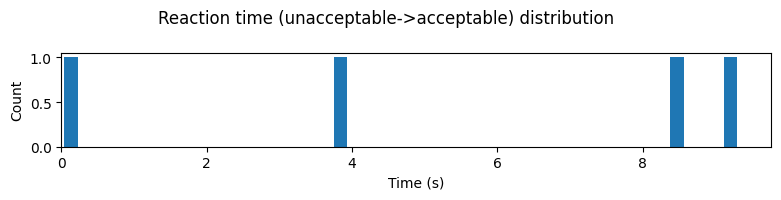

In [25]:
# 1. The time from when a task becomes unacceptable to when it becomes acceptable again.
# this can be done using the unacceptable intervals.
reaction_times = unacceptable_intervals[:,1] - unacceptable_intervals[:,0]
fig = plt.figure(figsize=(8, 2))
plt.hist(reaction_times, bins=50)
fig.suptitle("Reaction time (unacceptable->acceptable) distribution")
fig.gca().set_xlim(0, reaction_times.max() + 0.05 * reaction_times.max())
fig.gca().set_xlabel("Time (s)")   
fig.gca().set_ylabel("Count")
fig.tight_layout()
plt.show()

We can see above that there is a fast reaction time (close to 0). This happened because the task became unacceptable at the very end of the trial. We need to watch out for cases like this in the analysis and decide what to do with them! Perhaps we just filter out any reaction times that are too short, or are too close to the end of the trial.

[[ 5.10913897  9.30292797]
 [15.10937715 21.58915806]
 [25.11493611 25.94941401]]
Tasked fixed itself: 0
Total reaction intervals: 3
Mean reaction time: 3.8360159397125244


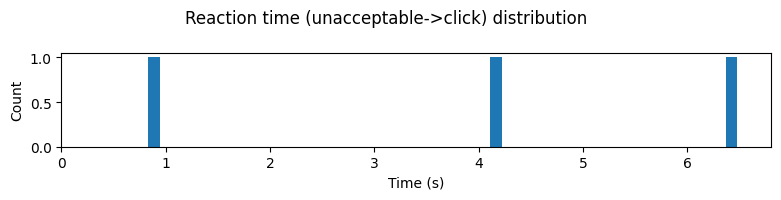

In [27]:
#2. The time from when a task becomes unacceptable to when the user interacts with it (clicks). 
# For this we need to compare the acceptability timestamps with the click (or user input) timestamps.
# The user input timestamps are part of `df`, specifically the rows where `user` is True as 
# these indicate when the user made a change to the task

# get only user triggered changes to the task
df_user = df[df["user"]][["timestamp"]].copy()
df_user['reaction'] = True

# get the start times of the unacceptable intervals
unacceptable_timestamps = unacceptable_intervals[:,0]
df_un = pd.DataFrame(unacceptable_timestamps, columns=['timestamp'])
df_un['reaction'] = False

# combine the two dataframes and sort by timestamp
df_all = pd.concat([df_user[["timestamp", "reaction"]], df_un])
df_all = df_all.sort_values(by="timestamp").reset_index(drop=True)
# find the intervals in the sorted dataframe
si = df_all.index[~df_all["reaction"]] # index of the start of the unacceptable interval
ei = si + 1 # index of the first user interaction after the unacceptable interval started
# check that ei is not out of bounds (this means the user did not react after the task became unacceptable)
# this can happen at the end of the trial, we can either:
# 1. filter out these cases
# COMMENT THIS IF YOU WANT CASE 2. BELOW
si = si[ei < len(df_all)]
ei = ei[ei < len(df_all)]

# 2. assume that the user did not react and use the final timestamp in the reaction time interval.
# UNCOMMENT THIS IF YOU WANT TO DO THIS
# df_all.loc[len(df_all)] = {"timestamp" : end_time, "reaction" : True}

reaction_intervals = np.stack([df_all.iloc[si]['timestamp'].to_numpy(), df_all.iloc[ei]['timestamp'].to_numpy()], axis=1)

# it is possible (but very unlikely) that the task fixed itself (no user interaction)
# We can filter these out using the reaction column - keep only those intervals that are a reaction.
filter_i = df_all.iloc[ei]["reaction"].to_numpy()
reaction_intervals = reaction_intervals[filter_i]
reaction_times = reaction_intervals[:,1] - reaction_intervals[:,0]
print(reaction_intervals)
print("Tasked fixed itself:", np.sum(~filter_i))
print("Total reaction intervals:", len(reaction_times))
print("Mean reaction time:", np.mean(reaction_times))

fig = plt.figure(figsize=(8, 2))
plt.hist(reaction_times, bins=50)
fig.suptitle("Reaction time (unacceptable->click) distribution")
fig.gca().set_xlim(0, reaction_times.max() + 0.05 * reaction_times.max())
fig.gca().set_xlabel("Time (s)")   
fig.gca().set_ylabel("Count")
fig.tight_layout()
plt.show()




**NOTE**: we are using the logging timestamp associated with the user interaction and NOT the time at which the mouse was actually clicked. The difference between these values is typically very small (< 1ms), for a comparison between users this is fine since they will all be affected equally. If you really want to use the mouse click time, things will get a little more complicated, but it is possible to do this by using the `get_mouse_button_events` function. Some additional processing will be required to match the clicks with corresponding changes in the task state.

In [ ]:
#3. The time from when a task becomes unacceptable to when the user attends again (fixation).
# This is very similar to the unacceptable->click reaction time, but using fixation timestamps instead of click timestamps.
# For this we need to use the `get_fixation_intervals` function.

# TODO: implement this.